In [3]:
%matplotlib inline
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import collections
#import pyfluidsynth

from pathlib import Path
import pretty_midi
import librosa.display
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

%run midi_util.py

folder = 'train/'

# A. Preprocess Midi file
#### Choose a harmony and a melody track from a MIDI file

In [4]:
## PARAMS
# highest note is melody
LOW = 48 # C2=48, C3=60, C4=72, C5=84, C6=96
HIGH = 84 # range(48,84) = 36 notes 

# input sizes
MELODY = 37 
TIMES = 48
CHORDS = 12
INPUTSHAPE = MELODY + TIMES + CHORDS*2
INPUTSHAPE

109

In [5]:
# MIDI processing
def getMelodyAndHarmony(file):
    def padAndAdd(a,b):
        return sorted(a+b,key= lambda x:x.start)
    
    pm = pretty_midi.PrettyMIDI(file)
    pm.remove_invalid_notes()
    print("\nEasy Processing: "+file)
    
    if len(pm.instruments) == 1:
        print("Both: Using only track for both harmony and melody")
        pianoroll = pm.instruments[0].notes
        return {'melody': pianoroll, 'harmony': pianoroll}
    
    else:
        maxlen = 0
        pianos = []
        guitars = []
        melodies = []
        for i, elt in enumerate(pm.instruments):
            if pm.instruments[i].is_drum:
                continue
            pianoroll = pm.instruments[i].get_piano_roll().T
            numnotes = pianoroll.nonzero()[0].shape[0]
            if numnotes > maxlen:
                mostnotes = i
                maxlen = numnotes
            if 'piano' in pm.instruments[i].name.lower():             #if pm.instruments[i].program in range(8): # MIDI 0..7 are pianos
                pianos.append((pm.instruments[i].notes,numnotes))
            if 'guitar' in pm.instruments[i].name.lower():             #if pm.instruments[i].program in range(24,32):
                guitars.append((pm.instruments[i].notes,numnotes))
            if 'melody' in pm.instruments[i].name.lower():
                # melodies.append((pianoroll,numnotes)) do i really want to padandadd two melodies always??
                melodies.append(pm.instruments[i].notes)

        if pianos != []:
            print("Harmony: Using piano with most notes as harmony of", len(pianos))
            pianowithmostnotes = max(pianos, key=lambda x: x[1])
            harmonytrack = pianowithmostnotes[0]
        elif guitars != []:
            print("Harmony: Using guitar with most notes as harmony of", len(guitars))
            guitarwithmostnotes = max(guitars, key=lambda x: x[1])
            harmonytrack = guitarwithmostnotes[0]
        else:
            print("Error: no piano or guitar track found")
            harmonytrack = pm.instruments[0].notes
            return

        if len(melodies) == 1:
            print("Melody: using only melody track as melody")
            melodytrack = melodies[0]
        elif len(melodies) == 2:
            print("Melody: padding and adding two melodies to one")
            melodytrack = padAndAdd(melodies[0], melodies[1])
        elif len(melodies) > 2:
            print("Melody: more than 2 melody tracks. padding and adding first two of # ", len(melodies),"melodies.")
            melodytrack = padAndAdd(melodies[0], melodies[1])
        else:
            print("Error: no melody track found.")
            melodytrack = pm.instruments[0].notes
            return

        return {'melody': melodytrack, 'harmony': harmonytrack}

def oneHot(idx, arraysize):
        if idx > arraysize:
            print("error idx > arraysize")
            return
        ar = np.zeros(arraysize)
        ar[idx] = 1
        return ar

def processMidi(file):
    pm = pretty_midi.PrettyMIDI(file)
    tracks = getMelodyAndHarmony(file)

    pmnotes = tracks['melody']
    notes, times = [], []
    currenttime = 0
    for i, note in enumerate(pmnotes):
        if note.start > currenttime:
            notes.append(MELODY-1)
            duration = pm.time_to_tick(note.start-currenttime)
            times.append(duration)
        if note.pitch in range(LOW,HIGH):
            notes.append(note.pitch - LOW)
        else:
            notes.append(note.pitch % 12)
        if i < len(pmnotes)-1 and pmnotes[i+1].start < note.end:
            times.append(pm.time_to_tick(pmnotes[i+1].start-note.start))
        else:
            times.append(pm.time_to_tick(note.end-note.start))
        currenttime = note.end
    times = np.array(np.round(np.array(times)/pm.resolution*12),dtype=np.int32)
    
    #cleanup
    times[np.where(times > 48)[0]] = 48
    
    notes = np.array(notes)[np.where(times>0)[0]]
    times = times[np.where(times > 0)[0]]
    times = times - 1 # reshift to 0..47
    
    
    # getChords
    pmnotes = tracks['harmony']
    notesDict = {}
    for i, note in enumerate(pmnotes):
        startbeat = int(pm.time_to_tick(note.start)/pm.resolution)
        endbeat = int(pm.time_to_tick(note.end)/pm.resolution)
        for j in range(startbeat, endbeat): #evry beat
            notesDict[j] = notesDict.get(j,np.zeros(12)) + oneHot(note.pitch % 12,12)

    # append for every beat (timestep) a vector. either np.zeros or chordinfovector
    chords = []
    for i in range(max(notesDict)): 
        chords.append(notesDict.get(i,np.zeros(12)))
    chordsByBeat = np.array(chords)

    # connect notes and chords
    currbeat = 0
    newchords = []
    for time in times:
        beat = int(currbeat/12)
        newchord = np.zeros(12)
        for j in range(int((time)/12)+1): 
            newchord += chordsByBeat[j+beat]
        newchords.append(newchord)
        currbeat += time
    chords = np.array(newchords)
    
    return notes, times, chords, chordsByBeat

In [6]:
# Input representation
def getCircleOfThirds(note):
    """input: note, scalar in [0,C)
    output: array, size (11,) including 3 bits for octave, 1 for rest
    """
    circleMajor = lambda x: x%4
    circleMinor = lambda x: x%3
    representation = np.zeros(11)
    if note < MELODY-1:
        absnote = note % 12
        octave = int(note/12)
        representation[7+octave] = 1
        representation[circleMajor(absnote)] = 1
        representation[4+circleMinor(absnote)] = 1
    else:
        representation[-1] = 1
    return representation

def getDuration(duration):
    """input size (1,) in [0,48)
       output size (6,)
    """
    return np.unpackbits(np.uint8(duration))[2:]

def getChord(chord):
    """input size (12,)
    outputs current and next chord shape (7,)
    """
    repre = np.zeros(7)
    for i, elt in enumerate(chord):
        x = elt * getCircleOfThirds(i)[:7]
        repre += x
    return repre

def getFeatureVectors(notes, times, chords, encodingDict, modulation=False): #TODO modulation ueberdenken
    """input size [7(pitch)+2(octaves)+1(Rest)]+6(duration)+7(chords)+7(nextchords)=30=Fsize #TODO: maybe change chords
    Creates Feature Vector from notes lists.
    Input: notes, times, chords from processMIDI
    Output: features array, size: (N, Fsize)  Fsize varies
    """
    features = []
    for i, note in enumerate(notes[:-1]):
        feature = np.empty(0)
        if encodingDict['melody']:
            elt = np.zeros(MELODY)
            if notes[i] == MELODY-1:
                elt[notes[i]] = 1
            elif notes[i] < MELODY-1:
                elt[notes[i]] = 1 # melody bit
            else:
                print("melody over 37")
            feature = np.concatenate((feature,elt))
        if encodingDict['melodyEncoded']: # pitch+octave+rest
            feature = np.concatenate((feature,getCircleOfThirds(note)))
        if encodingDict['duration']:
            elt = np.zeros(48)
            elt[int(times[i])] = 1
            feature = np.concatenate((feature,elt))  
        if encodingDict['durationEncoded']:
            feature = np.concatenate((feature,getDuration(times[i])))
        if encodingDict['chordsNormally']:
            feature = np.concatenate((feature,chords[i]))
            feature = np.concatenate((feature,chords[i+1]))
        if encodingDict['chordsEncoded']:
            feature = np.concatenate((feature,getChord(chords[i])))  # chord ERROR: MAKE THIS BETTER
            feature = np.concatenate((feature,getChord(chords[i+1])))   # chord ERROR: MAKE THIS BETTER
        features.append(feature)
    features = np.array(features)
    return features

def getInputSequences(notes, times, chords, encodingDict, modulation=False, padding=False, seq_len=16):
    """Create Net Input.
    Input: features from getFeatureVectors or getEncodedFeatureVectors
    Output: 
        - Sequences, size: (157, seq_len)
        - Labels, one-hot, size: (MELODY,) # TODO: add times to label
    """
    features = getFeatureVectors(notes, times, chords, encodingDict, modulation)
    sequences = []
    labels = []
    i = 0
    if padding == True:
        padded_notes = np.concatenate((np.zeros((seq_len,features.shape[1])),features[:seq_len]))
        for j in range(seq_len):
            sequences.append(padded_notes[j:j+seq_len])
            label_pitch = notes[j]
            label_duration = times[j]
            labels.append((label_pitch, label_duration))
    while i+seq_len < features.shape[0]:
        sequences.append(features[i:i+seq_len])
        label_pitch = notes[i+seq_len]
        label_duration = times[i+seq_len]
        labels.append((label_pitch, label_duration))
        i += 1     # or += seq_len
        
    sequences = np.array(sequences)
    labels = np.array(labels)
    return sequences, labels

In [7]:
# Choose encoding and load files
encodingDict = {
    'melody': True,
    'melodyEncoded': True,
    'duration': False,
    'durationEncoded': True,
    'chordsNormally': True,
    'chordsEncoded': True
}

# B. Load Data

In [55]:
files = os.listdir("train")
files.remove('.DS_Store')
files = ["autumnleaves.mid"]
for i, file in enumerate(files):
    notes, times, chords, _ = processMidi(folder+file)
    sequences, labels = getInputSequences(notes, times, chords, encodingDict, modulation=False, padding=False, seq_len=16)
    X = sequences if i==0 else np.concatenate((X, sequences))
    y = labels if i==0 else np.concatenate((y, labels))
    
X.shape, y.shape


Easy Processing: train/autumnleaves.mid
Harmony: Using piano with most notes as harmony of 1
Melody: padding and adding two melodies to one


((269, 16, 92), (269, 2))

In [56]:
# train/val split
n = 3000
n = min(n,X.shape[0])
data = X[:n]
labels = y[:n]

perm = np.random.permutation(n)
p = int(0.8*n)

train_data = data[perm[:p]]
train_labels = labels[perm[:p]]
val_data = data[perm[p:]]
val_labels = labels[perm[p:]]

train_data.shape, train_labels.shape

((215, 16, 92), (215, 2))

### Load Data for Pytorch

In [57]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, transform=None):
        super(Dataset, self).__init__()
        self.inputs = inputs
        self.labels = labels
        self.transform = transform
       
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        inputs = self.inputs[idx]
        label = self.labels[idx]
        if self.transform: 
            inputs = self.transform(inputs)
        return inputs, label
    
def getDataLoader(data, labels, batch_size=32, shuffle=True, sample=False):
    dataset = Dataset(data, labels)   

    if sample:
        counter = collections.Counter(train_labels[:,0])
        
        for elt in counter:
            counter[elt] = 1. / counter[elt]
        weights  = []
        for i in range(MELODY): 
            weights.append(counter.get(i,0))
        weights = torch.Tensor(weights)
        train_weights=weights[train_labels[:,0]]
        sampler = torch.utils.data.WeightedRandomSampler(weights=train_weights,num_samples=len(train_weights),replacement=True)
        train_loader = torch.utils.data.DataLoader(dataset=dataset, sampler=sampler, batch_size=batch_size, shuffle=False)
    else:
        train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    return train_loader


# C. Train a model

In [58]:
#####################
# Build model
#####################

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim_pitch, output_dim_duration, num_layers=1, dropout=0.5):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim_pitch = output_dim_pitch
        self.output_dim_duration = output_dim_duration
        self.num_layers = num_layers
        self.hidden = self.init_hidden(batch_size)

        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.bn2 = nn.BatchNorm1d(self.hidden_dim)
        
        self.linear_pitch = nn.Linear(self.hidden_dim, self.output_dim_pitch)
        self.linear_duration = nn.Linear(self.hidden_dim, self.output_dim_duration)
        
        
        print("Nr. of params:", self.get_nr_params())
    
    def get_nr_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        return params

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))

    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        
        # Only take the output from the final timetep
        fc_input = lstm_out[:,-1,:]
        #fc_input = self.bn2(lstm_out[:,-1,:])
        
        pitch = self.linear_pitch(fc_input)
        duration = self.linear_duration(fc_input)
        # log_probs = F.log_softmax(y_pred,dim=1) # crossentropy is already with softmax
        return pitch, duration

def train(model, train_loader, val_loader, optim, loss_fn, num_epochs=100):

    hist = np.zeros(num_epochs)

    def clip_gradient(model, clip_value):
        params = list(filter(lambda p: p.grad is not None, model.parameters()))
        for p in params:
            p.grad.data.clamp_(-clip_value, clip_value)

    for t in range(num_epochs):
        loss_curr = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            batch_size = inputs.size(0)
            model.hidden = model.init_hidden(batch_size)

            optim.zero_grad()
            pitch, duration = model(inputs.float())
            #print(pitch.shape)

            loss_pitch = loss_fn(pitch, labels[:,0].long())
            loss_duration = loss_fn(duration, labels[:,1].long())

            loss = loss_pitch + loss_duration

            loss.backward(retain_graph=True)
            #clip_gradient(model, 1e-1)
            optim.step()

            loss_curr = loss_curr + loss.item()

        hist[t] = loss_curr
        if t%10==0:
            notes = t%50==0
            acc_train, dacc_train = evaluation(model, train_loader, notes)
            acc_val, dacc_val = evaluation(model, val_loader, notes=False)
            print("loss: ", np.round(hist[t], 4), "acc_train: ", np.round(acc_train,2), "acc_val: ", np.round(acc_val,2))
            print("loss: ", np.round(hist[t], 4), "dacc_train: ", np.round(dacc_train,2), "dacc_val: ", np.round(dacc_val,2))

    plt.plot(hist, label="Training loss")
    plt.legend()
    plt.show()
    

def evaluation(model, loader, notes=False):
    model.eval()
    correct, total, dcorrect, dtotal = 0,0,0,0 
    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        batch_size = inputs.size(0)
        model.hidden = model.init_hidden(batch_size)

        pitch, duration = model(inputs.float())
        
        _, predicted = torch.max(pitch.data, 1)
        total += labels[:,0].size(0) 
        correct += (predicted == labels[:,0].long()).sum().item()
        
        _, dpredicted = torch.max(duration.data, 1)
        dtotal += labels[:,1].size(0) 
        dcorrect += (dpredicted == labels[:,1].long()).sum().item()
        
        if notes and i == 0:
            print(predicted)
            print(labels[:,0])
    
    acc = int(100 * correct / total)
    dacc = int(100 * dcorrect / dtotal)
    model.train()
    return acc, dacc

### Training: we need 3 things: 
- Data(loader), 
- Model, 
- Optimization(Training)

In [59]:
# Data(loader)
batch_size = 32
train_loader = getDataLoader(train_data, train_labels, batch_size, sample=True)
val_loader = getDataLoader(train_data, train_labels, batch_size, shuffle=False)

# Model
model_params = {
    'input_dim': train_data.shape[-1],
    'hidden_dim': 64,
    'num_layers': 2,
    'output_dim_pitch': MELODY,
    'output_dim_duration': TIMES
}

model = LSTM(**model_params)

Nr. of params: 79381


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


tensor([11, 26, 19, 11, 24, 22, 11, 26, 25, 16, 12, 23, 26, 23, 22, 23, 21, 18,
        16, 18, 15, 24, 14, 18, 21, 11, 22, 12, 11, 18, 14, 12])
tensor([11, 26, 19, 11, 36, 22, 11, 26, 25, 16, 12, 23, 26, 23, 22, 24, 36, 18,
        16, 18, 18, 24, 14, 16, 21, 36, 22, 12, 11, 18, 14, 12])
loss:  8.0652 acc_train:  86 acc_val:  43
loss:  8.0652 dacc_train:  84 dacc_val:  46
loss:  7.6509 acc_train:  87 acc_val:  48
loss:  7.6509 dacc_train:  86 dacc_val:  48
loss:  6.2503 acc_train:  88 acc_val:  49
loss:  6.2503 dacc_train:  87 dacc_val:  51
loss:  6.5705 acc_train:  91 acc_val:  53
loss:  6.5705 dacc_train:  91 dacc_val:  53
loss:  6.2948 acc_train:  93 acc_val:  54
loss:  6.2948 dacc_train:  92 dacc_val:  52
tensor([15, 22, 11, 13, 19, 12, 15, 22, 16, 11, 21, 24, 14, 26, 13, 24, 23, 13,
        16, 24, 21, 26, 15, 15, 13, 19, 18, 13, 24, 25, 25, 16])
tensor([15, 22, 11, 13, 36, 12, 15, 22, 16, 11, 21, 24, 36, 26, 13, 24, 23, 13,
        16, 24, 21, 26, 15, 15, 13, 18, 18, 13, 24, 25,

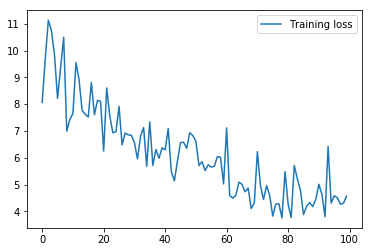

In [69]:
# Training(Optimizer)
train_params = {
    'train_loader': train_loader,
    'val_loader': val_loader,
    'optim': torch.optim.Adam(model.parameters(), lr=1e-3),
    #optim: torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9),
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'num_epochs': 100
}

train(model, **train_params)

In [61]:
torch.save(model.state_dict(), 'weights/model'+datetime.datetime.now().strftime("%Y-%m-%d%H:%M:%S")+'.pt')

In [42]:
torch.save(model.state_dict(), 'weights/model1'+'.pt')

In [44]:
model.load_state_dict(torch.load('weights/model1'+'.pt'))

# Test Framework

In [64]:
# read test midi file ignore labels and get output from network
# create midi file with input midi and prediction from network
# simply read midi here to see how it sounds + plot

def writeMidi(notes, times, file, originalfile, tempo=120, resolution=12):
    pm = pretty_midi.PrettyMIDI(resolution=resolution, initial_tempo=tempo)
    pminst = pretty_midi.Instrument(program=0)
    currtime = 0
    for i, note in enumerate(notes):
        if note != MELODY-1:
            pitch = note+LOW
            start = pm.tick_to_time(int(currtime))
            end = pm.tick_to_time(int(currtime+times[i]))
            if end > start:
                pmnote = pretty_midi.Note(velocity=100, pitch = pitch, start=start, end=end)
                pminst.notes.append(pmnote)
        currtime += times[i]+1
    pm.instruments.append(pminst)
    
    #get original chords from file
    ogpm = pretty_midi.PrettyMIDI(originalfile)
    originalchords = pretty_midi.Instrument(program=0)
    originalnotes = getMelodyAndHarmony(originalfile)['harmony']
    for i, note in enumerate(originalnotes):
        old = ogpm.time_to_tick(note.start)
        start = pm.tick_to_time(int(ogpm.time_to_tick(note.start)/ogpm.resolution*pm.resolution))
        end = pm.tick_to_time(int(ogpm.time_to_tick(note.end)/ogpm.resolution*pm.resolution))
        originalchords.notes.append(pretty_midi.Note(velocity=50, pitch=note.pitch, start=start, end=end))
    pm.instruments.append(originalchords)

    pm.write(file)
    return pm


# legacy
def getPredictedNotes(notes, times, chords):
    test_data, test_labels = getInputSequences(notes,times,chords,encodingDict)
    
    test_loader = getDataLoader(test_data,test_labels, batch_size=32, shuffle=False)
    
    predicted_notes = np.empty(0)
    predicted_durations = np.empty(0)
    model.eval()
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        batch_size = inputs.size(0)
        model.hidden = model.init_hidden(batch_size)

        pitch, duration = model(inputs.float())

        _, pred_pitch = torch.max(pitch.data, 1)
        _, pred_duration = torch.max(duration.data, 1)
        predicted_notes = np.concatenate((predicted_notes,pred_pitch.detach().numpy()))
        predicted_durations = np.concatenate((predicted_durations, pred_duration.detach().numpy()))
    return predicted_notes, predicted_durations

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
     
    
def tradeFour(notes, times, chords, chordsByBeat):
    predicted_notes, predicted_durations = [], []
    mel_len=16+1 # wegen nextChord

    notesnew = np.array(notes[-mel_len:])
    timesnew = np.array(times[-mel_len:])
    chordsnew = np.array(chords[-mel_len:])

    currentbeat = 0
    currenttime = 0
    while sum(predicted_durations) < 4*TIMES:
        feat = getFeatureVectors(notesnew, timesnew, chordsnew, encodingDict)
        feat = torch.Tensor(feat).unsqueeze(0)

        model.hidden = model.init_hidden(feat.size(0))
        pitch, duration = model(feat.float())

        pred_pitch = torch.max(pitch.data, 1)[1].detach().numpy()[0]
        pred_duration = torch.max(duration.data, 1)[1].detach().numpy()[0]

        predicted_notes.append(pred_pitch)
        predicted_durations.append(pred_duration)
        notesnew = np.append(notesnew[1:], pred_pitch)
        timesnew = np.append(timesnew[1:], pred_duration)
        
        if int(currenttime/12) > currentbeat:
            newchord = chordsByBeat[int(currenttime/12)]
            chordsnew = np.append(chordsnew[1:], newchord)
        currenttime += pred_duration
        currentbeat += int(currenttime/12)
        
        print(predicted_durations)
        
    notes = np.append(notes, np.array(predicted_notes))
    times = np.append(times, np.array(predicted_durations))

    return notes, times
    
def plotTradeFour(file):
    notes, times, chords, chordsByBeat = processMidi(file)
    
    notes, times = tradeFour(notes, times, chords, chordsByBeat)
    
    # plotWithAudio
    pm = writeMidi(notes, times, 'treval/newtest.mid', file)
    plt.figure(figsize=(8, 4))
    plot_piano_roll(pm, LOW, HIGH)
    display(IPython.display.Audio(pm.synthesize(fs=44000), rate=44000))   
    


Easy Processing: test/testautumnleaves7.mid
Harmony: Using piano with most notes as harmony of 1
Melody: using only melody track as melody
[30]
[30, 30]
[30, 30, 32]
[30, 30, 32, 14]
[30, 30, 32, 14, 47]
[30, 30, 32, 14, 47, 47]

Easy Processing: test/testautumnleaves7.mid
Harmony: Using piano with most notes as harmony of 1
Melody: using only melody track as melody


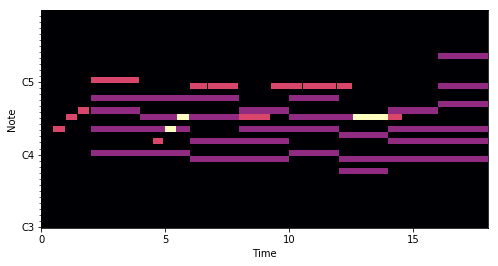

In [70]:
plotTradeFour('test/testautumnleaves7.mid')

## Test A

In [43]:
# test how much % model can learn a melody

# define test melody
# train network
# give percentage of how much it learnt

chordsDict={
    'C': [1,0,0,0,1,0,0,1,0,0,0,0],
    'C7': [1,0,0,0,1,0,0,1,0,0,1,0],
    'Cmaj7': [1,0,0,0,1,0,0,1,0,0,0,1]
}

In [118]:
# test data
notes = [0,2,4,7,7,4,2,0,0,2,4,7,7,4,2,0,0,5,3,4,5,8,7,5,0,2,4,7,7,4,2,0]
times = np.ones(32)*8
chord = chordsDict['C']
chords = np.repeat(chord, 32).reshape((12,-1)).T
encoding = True
train_data, train_labels = getInputSequences(notes, times, chords, encoding=encoding, modulation=False, padding=False, seq_len=1)

display(train_data.shape)
batch_size = 32
train_loader = getDataLoader(train_data, train_labels, batch_size=batch_size, shuffle=False)

# test model
model_params = {
    'input_dim': train_data.shape[-1],
    'hidden_dim': 64,
    'num_layers': 1,
    'output_dim_pitch': MELODY,
    'output_dim_duration': TIMES,
    'dropout': 0
}

testmodel = LSTM(**model_params)


(15, 16, 31)

Nr. of params: 30485


tensor([2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0])
tensor([0., 5., 3., 4., 5., 8., 7., 5., 0., 2., 4., 7., 7., 4., 2.],
       dtype=torch.float64)
loss:  7.3719 acc_train:  6 acc_val:  6
loss:  1.8806 acc_train:  20 acc_val:  20
loss:  1.8009 acc_train:  26 acc_val:  26
loss:  1.6949 acc_train:  33 acc_val:  33
loss:  1.5203 acc_train:  53 acc_val:  53
tensor([0, 5, 8, 4, 5, 8, 7, 5, 0, 7, 4, 7, 5, 4, 7])
tensor([0., 5., 3., 4., 5., 8., 7., 5., 0., 2., 4., 7., 7., 4., 2.],
       dtype=torch.float64)
loss:  1.2851 acc_train:  73 acc_val:  73
loss:  1.0255 acc_train:  80 acc_val:  80
loss:  0.8072 acc_train:  86 acc_val:  86
loss:  0.6302 acc_train:  86 acc_val:  86
loss:  0.4656 acc_train:  93 acc_val:  93
tensor([0, 5, 3, 4, 5, 8, 7, 5, 0, 2, 4, 7, 7, 4, 2])
tensor([0., 5., 3., 4., 5., 8., 7., 5., 0., 2., 4., 7., 7., 4., 2.],
       dtype=torch.float64)
loss:  0.3227 acc_train:  100 acc_val:  100
loss:  0.2176 acc_train:  100 acc_val:  100
loss:  0.1449 acc_train:  100 acc_val:  1

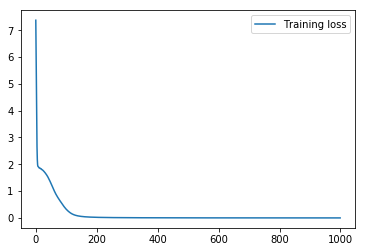

In [119]:
train_params = {
    'train_loader': train_loader,
    'val_loader': train_loader,
    'optim': torch.optim.Adam(testmodel.parameters(), lr=1e-2),
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'num_epochs': 1000
}
train(testmodel, **train_params)

# Test B

In [ ]:
notes = np.ones(32)*8
times = [8]
chord = chordsDict['C']
chords = np.repeat(chord, 32).reshape((12,-1)).T
encoding = True
train_data, train_labels = getInputSequences(notes, times, chords, encoding=encoding, modulation=False, padding=False, seq_len=1)

display(train_data.shape)
batch_size = 32
train_loader = getDataLoader(train_data, train_labels, batch_size=batch_size, shuffle=False)

# test model
model_params = {
    'input_dim': train_data.shape[-1],
    'hidden_dim': 64,
    'num_layers': 1,
    'output_dim_pitch': MELODY,
    'output_dim_duration': TIMES,
    'dropout': 0
}

testmodel = LSTM(**model_params)


# Legacy

In [8]:
# smallest LSTM example
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True) # It was batch_first=True!
inputs = torch.randn(5, 300, 10)
hidden = (torch.randn(2, 5, 20), torch.randn(2, 5, 20))
output, hidden = rnn(inputs, hidden)
output.shape

torch.Size([5, 300, 20])

In [9]:
def standardize(data):
    """ Move {0,1} data to {-1,1}, then standardize. Standardize data in [0,1]"""
    data = data.astype(np.float32)
    standardized_data = (data - np.mean(data, axis=0)[None,:,:]) / np.std(data, axis=0)[None,:,:]
    return standardized_data